# Combining Different Models for Ensembe Learining

**Overview**

- [7.1 Learning with ensembles](#7.1-Learning-with-ensembles)
- [7.2 Combining classifiers via majority vote](#7.2-Combining-classifiers-via-majority-vote)
    - [7.2.1 Implementing a simple majority vote classifier](#7.2.1-Implementing-a-simple-majority-vote-classifier)
    - [7.2.2 Using the majority voting principle to make predictions](#7.2.2-Using-the-majority-voting-principle-to-make-predictions)
- [7.3 Evaluating and tuning the ensemble classifier](#7.3-Evaluating-and-tuning-the-ensemble-classifier)
- [7.4 Bagging: Building an ensemble of classifiers from bootstrap samples](#7.4-Bagging:-Building-an-ensemble-of-classifiers-from-bootstrap-samples)
    - [7.4.1 Bagging in a nutshell](#7.4.1-Bagging-in-a-nutshell)
    - [7.4.2 Applying bagging to classify samples in the Wine dataset](#7.4.2-Applying-bagging-to-classify-samples-in-the-Wine-dataset)
- [7.5 Leveraging weak learner via adaptive boosting](#7.5-Leveraging-weak-learner-via-adaptive-boosting)
    - [7.5.1 How boosting works](#7.5.1-How-boosting-works)
    - [7.5.2 Applying AdaBoost using scikit-learn](#7.5.2-Applying-AdaBoost-using-scikit-learn)

In [1]:
from IPython.display import Image
%matplotlib inline

## 7.1 Learning with ensembles
---

**Ensemble method**
- **Majority voting**

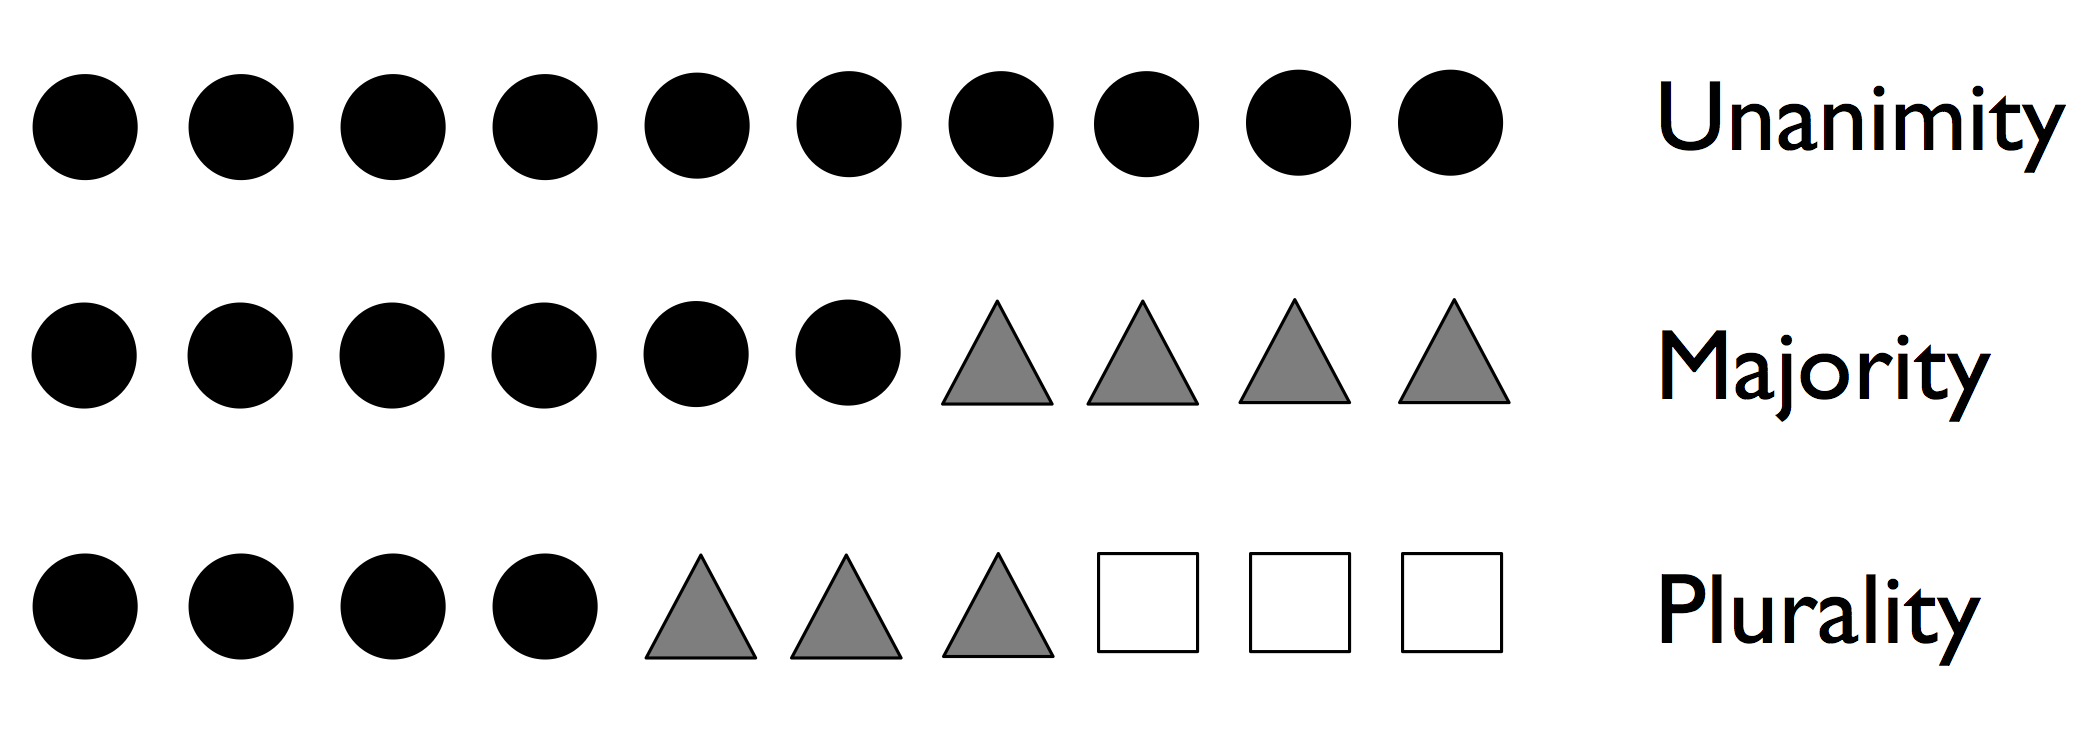

In [2]:
Image('img/07_01.png', width=500)

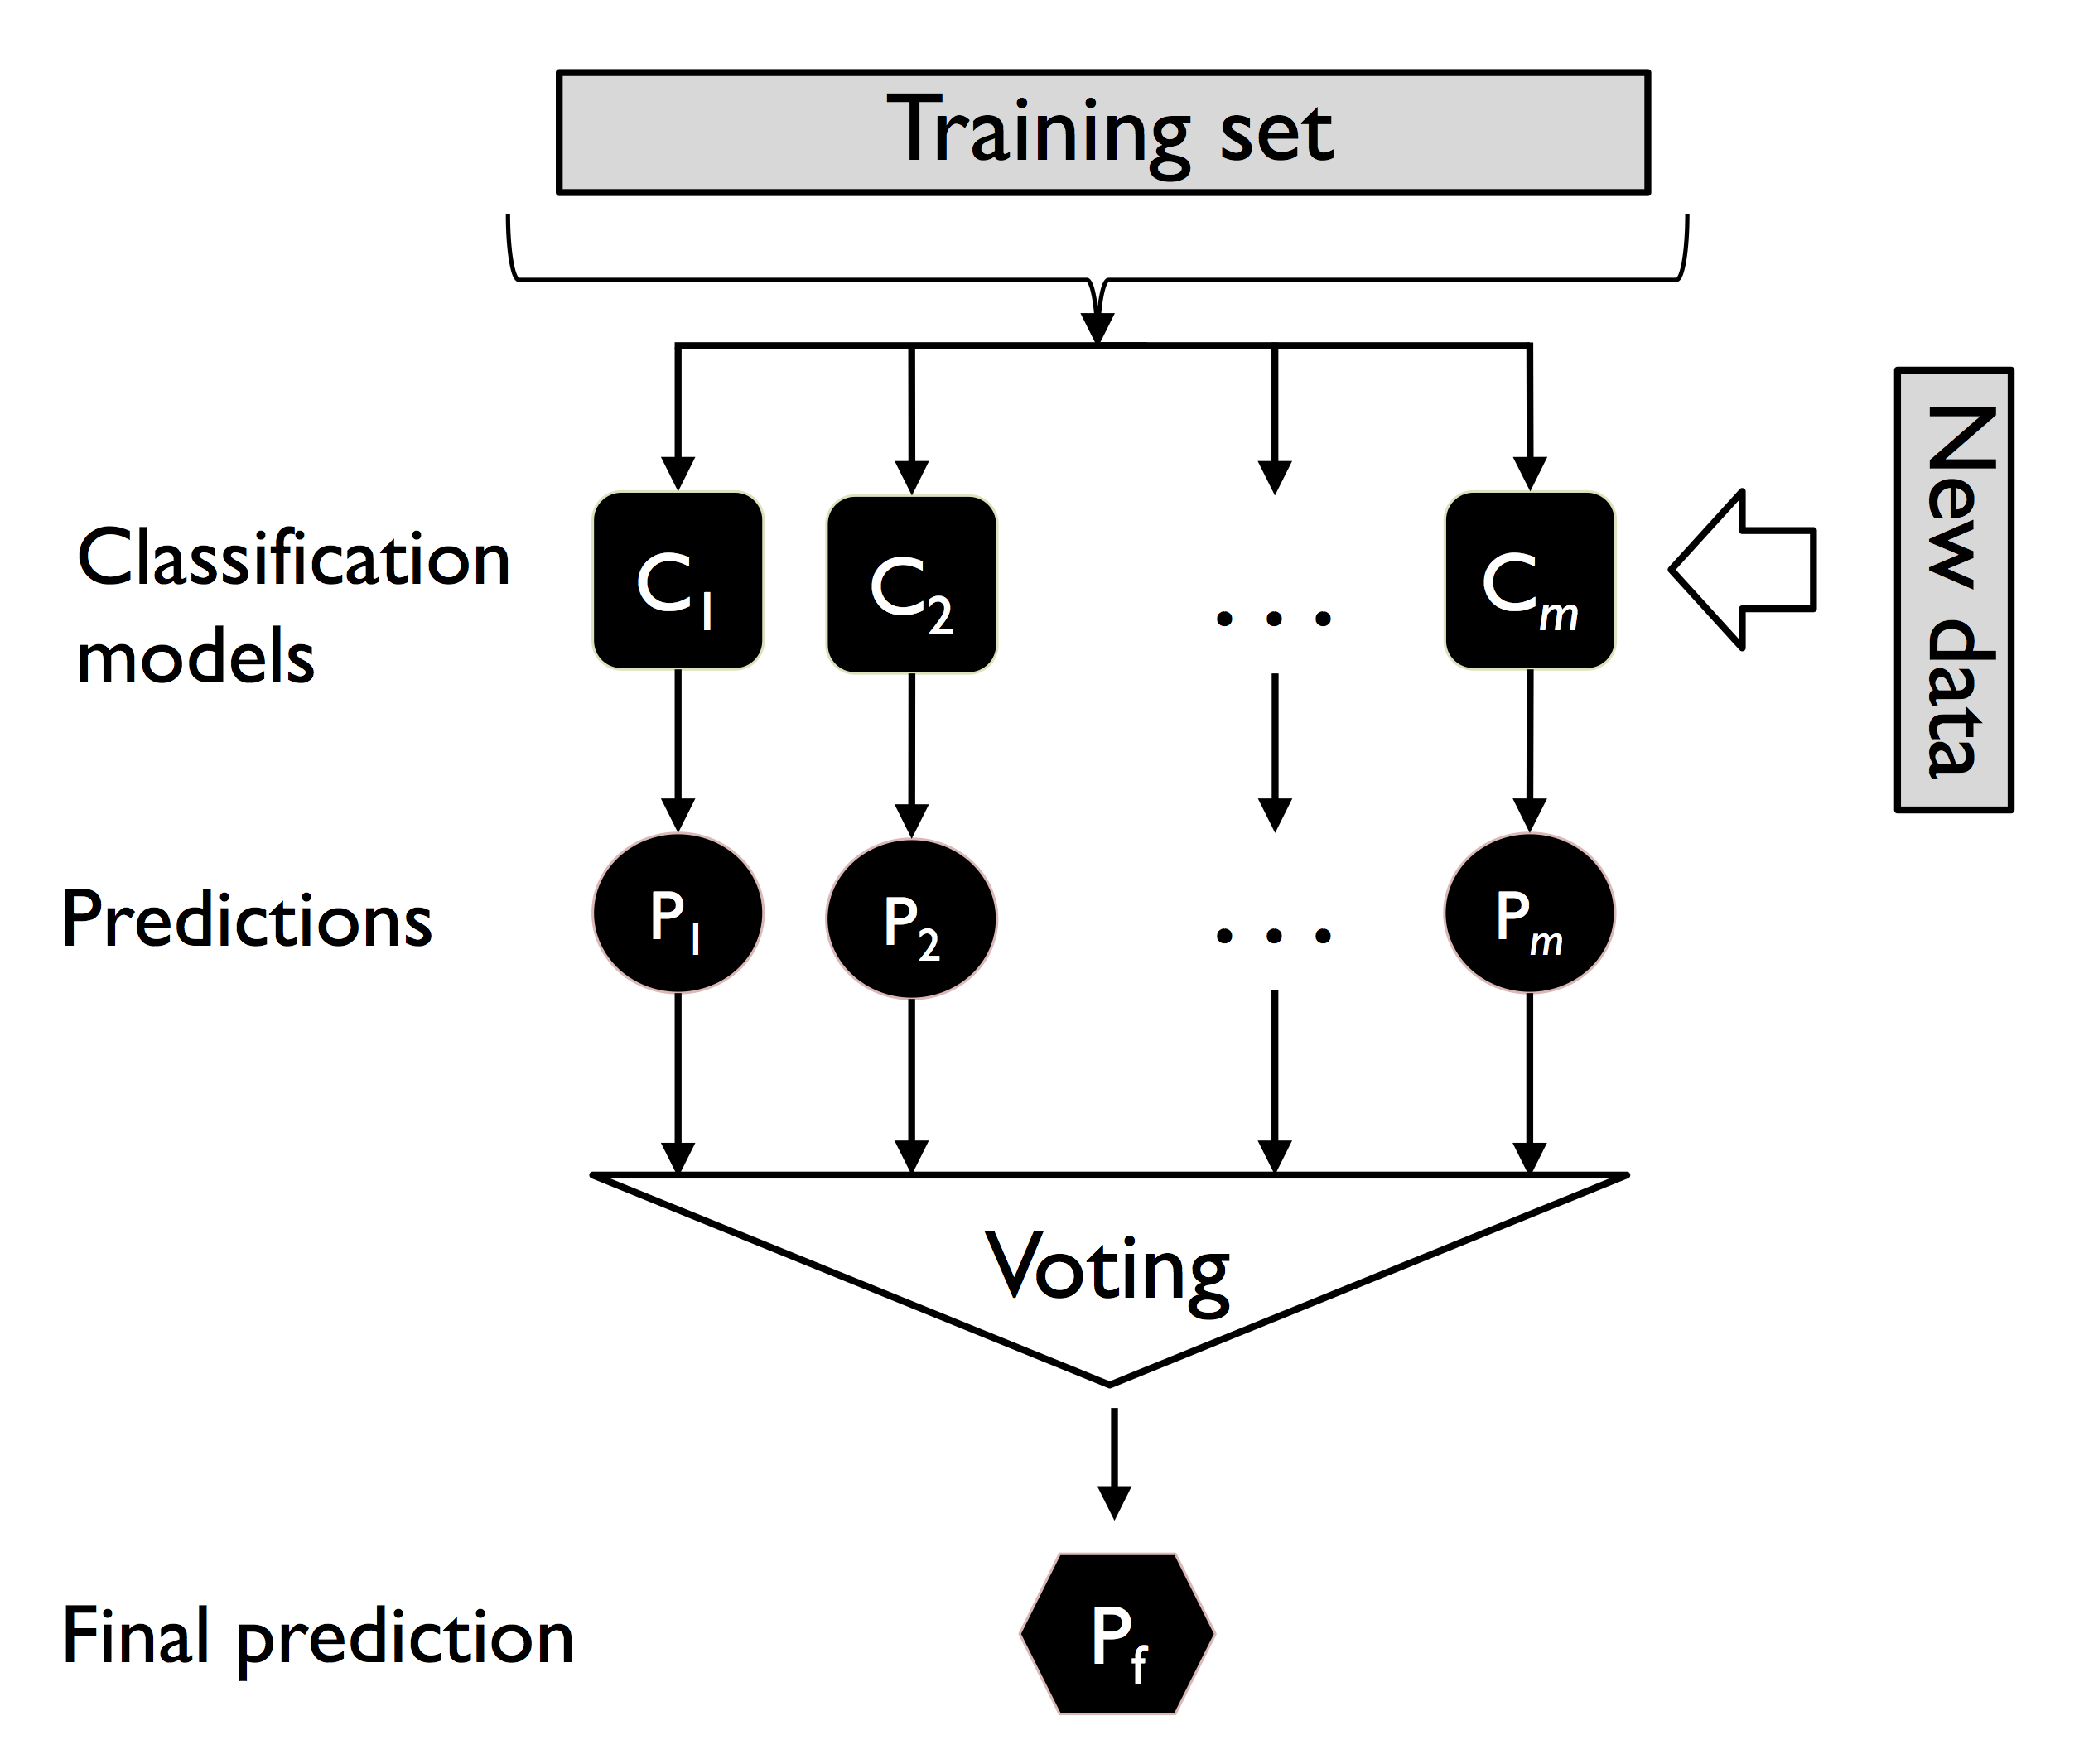

In [3]:
Image('img/07_02.png', width=500)

$$\widehat{y} = mode{C_1(x), C_2(x), ..., C_m(x}$$
(7.1.1)

- $C_j$: classifier
- $\widehat{y}$: 最も多い class label

$\text{class 1}=-1$, $\text{class 2}=+1$ のbinary classifier

$$
\begin{align*}
C(x) 
&= sign \Big[ \sum_{j}^{m} C_j(x) \Big] \\
&= 
\begin{cases}
1 & (\sum_j C_j(x) ≥ 0) \\
- 1 & (\sum_j C_j(x) ≥ 0)
\end{cases}
\end{align*}
$$

$$
\begin{align*}
P(y ≥ k) 
&= \sum_k^n 
\begin{pmatrix}
n \\
k
\end{pmatrix}
\epsilon ^k (1 - \epsilon)^{n - k} \\
&= \epsilon _{ensemble}
\end{align*}
$$

binary classification 
- $n$: num of classifier
- $\epsilon$: classification error
    - premise: ベースclassifier の$\epsilon$ は等しい

Given: 
- $n$: 11
- $\epsilon$: 0.25

$$
\begin{align*}
P(y ≥ k) 
&= \sum_{k = 6}^{11} 
\begin{pmatrix}
11 \\
k
\end{pmatrix}
0.25 ^k (1 - 0.25)^{n - k} \\
&= 0.034
\end{align*}
$$
(7.1.4)

> ---
> 
> $$\begin{pmatrix} n\\ k\end{pmatrix} = \frac{n!}{(n-k)!k!}$$
> 
> ---

In [4]:
from scipy.misc import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * 
             error**k * 
             (1 - error)**(n_classifier - k) 
             for k in range(k_start, n_classifier + 1)]

    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

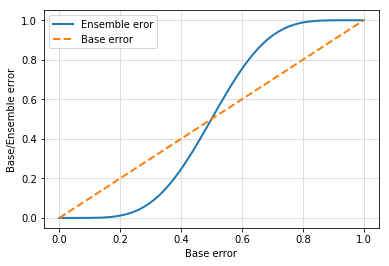

In [5]:
import numpy as np
import matplotlib.pyplot as plt

error_range = np.arange (0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) 
              for error in error_range]

import matplotlib.pyplot as plt

plt.plot(error_range, ens_errors, 
         label='Ensemble eror', linewidth=2)
plt.plot(error_range, error_range, 
         linestyle='--', label='Base error', linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

## 7.2 Combining classifiers via majority vote
---

### 7.2.1 Implementing a simple majority vote classifier
---

weight 付き

$$\widehat{y} = \arg \max_i \sum_{j = 1}^m w_j \chi_A (C_j (X) = i)$$
(7.2.1)

- $w_j$: base classifier $C_j$ の weight
- $\widehat{y}$: emsemble で予測された class label
- $\chi_A$: $[C_j(x) = i (\in A)]$ のcharacteristic fn (特性fn)
- $A$: class label の 集合

$$\widehat{y} = mode[C_1(x), C_2(x), ..., C_m(x)]$$
(7.2.2)

> ---
> 
> $mode$ mode (最頻値)
> 
> ---

$$
C_1(x) \rightarrow 0,  
C_2(x) \rightarrow 0, 
C_3(x) \rightarrow 1 \\
\widehat{y} = mode[0, 0, 1] = 0
$$
(7.2.3)

ここで, $C_3$のweight を0.6, $C_1$, $C_2$ のweight を 0.2

$$
\begin{align*}
\widehat{y} 
&= \arg \max_i \sum_{j = 1}^{m} w_j \chi_A (C_j(x) = i) \\
&= \arg \max_i [0.2 \times i_0 + 0.2 \times i_0 + 0.6 \times i_1] \\
&= 1
\end{align*}
$$

つまり, $\frac{0.6}{0.2} = 3$ 

$$\widehat{y} = mode [0, 0, 1, 1, 1] = 1$$
(7.2.5)

weight 付きに代えるには, `argmax` fn を `bincount` fn に

In [6]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

$$\widehat{y} = \arg \max_i \sum_{j = 1}^m w_j P_{ij}$$
(7.2.6)

- $P_{ij}$: class label $i$ に対して, $j$-th の classifier が予測したprob

- class label $i \in [0, 1]$
- classifier $C_j$, ($j \in {1, 2, 3}$)

$$
\begin{align*}
C_1(x) &\rightarrow [0.9, 0.1] \\
C_2(x) &\rightarrow [0.8, 0.2] \\
C_3(x) &\rightarrow [0.4, 0.6]
\end{align*}
$$
(7.2.7)

$$
\begin{align*}
p(i_0 | x) 
&= 0.2 \times 0.9 + 0.2 \times 0.8 + 0.6 \times 0.4 \\
&= 0.58 \\
p(i_1 | x) 
&= 0.2 \times 0.1 + 0.2 \times 0.2 + 0.6 \times 0.6 \\
&= 0.42 \\
\widehat{y} &= \arg \max_i [p(i_0 | x), p(i_1 | x)] = 0
\end{align*}
$$

`np.aveage`, `np.argmax`

In [7]:
ex = np.array([[0.9, 0.1], 
               [0.8, 0.2], 
               [0.4, 0.6]])

p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([ 0.58,  0.42])

In [8]:
np.argmax(p)

0

In [9]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """
    A majority vote ensemble classifier
    
    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
        Different classifier for the ensemble
        
    vote : str, {'classlabel', 'probability'} (default: 'classlabel')
        If 'classlabel' the prediction is based on the argmax of 
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).
        
    weights : array-like, shape = [n_classifiers] optional (default=None)
        If a list of 'int' or 'float' values are provided, the classifiers
        are weighted by importance; Uses uniform weights if 'weights=None'.
    
    """
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, 
                                  value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """
        Fit classifiers
        
        Paramters
        ---------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.
            
        y : array-like, shape = [n_samples]
            Vector of target class labels.
            
        Returns
        -------
        self : object
        
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'" 
                             "; got (vote=%r)" 
                             % self.vote)
            
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal' 
                             '; got %d weights, %d classifiers' 
                             % (len(self.weights), len(self.classifiers)))
        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """
        Predict class labels for X.
        
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.
        
        Returns
        -------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else: # 'classlabel' vote
            
            # Collect results from clf.predict calls 
            predictions = np.asarray([clf.predict(X) 
                                      for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(
                lambda x: 
                np.argmax(np.bincount(x, 
                                      weights=selfweights)), 
                axis=1, 
                arr=predictions)
            
        maj_vote = self.lablenc_.inverse_trainsform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """
        Predict class probabilities for X.
        
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
            
        Returns
        -------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per samle.
            
        """
        probas = np.asarray([clf.predict_proba(X) 
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """
        Get classifier parameter names for GridSearch
        """
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else: 
            out = self.named_classifiers.copy()
            
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

### 7.2.2 Using the majority voting principle to make predictions
---

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

Iris dataset の sample をtraining 50%, test 50% に

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)

3種類の classifier の training

- logistric regression
- decision tree
- k-nearest neighbors



In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001, 
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1, 
                              criterion='entropy', 
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1, 
                            p=2, 
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], 
                  ['clf', clf1]])

pipe3 = Pipeline([['sc', StandardScaler()], 
                  ['clf', clf3]])
clf_labels = ['Logistic regression', 'Decision tee', 'KNN']

print('10-fold cross varidation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (± %0.2f) [%s]" % (scores.mean(), scores.std(), label))

10-fold cross varidation:

ROC AUC: 0.87 (± 0.17) [Logistic regression]
ROC AUC: 0.89 (± 0.16) [Decision tee]
ROC AUC: 0.88 (± 0.15) [KNN]


In [13]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']

all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, 
                             X=X_train, 
                             y=y_train, 
                             cv=10, 
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (± %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.87 (± 0.17) [Logistic regression]
ROC AUC: 0.89 (± 0.16) [Decision tee]
ROC AUC: 0.88 (± 0.15) [KNN]
ROC AUC: 0.94 (± 0.13) [Majority voting]


## 7.3 Evaluating and tuning the ensemble classifier
---

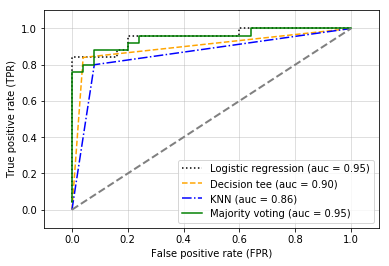

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # 陽性class の label は 1であることが前提
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, 
             color=clr, 
             linestyle=ls, 
             label='%s (auc = %0.2f)' % (label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 
         linestyle='--', 
         color='gray', 
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

In [15]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

# decision region を描画する min, max を生成
x_min = X_train_std[:, 0].min() -1
x_max = X_train_std[:, 0].max() +1
y_min = X_train_std[:, 1].min() -1
y_max = X_train_std[:, 1].max() +1

# grid point を生成
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), 
                     np.arange(y_min, y_max, 0.1))

# 描画領域を2x2に分割
f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

# 決定領域のplot, blue, red のscatter plot の作成などを実行
# var idx は各 classifier を描画するrow, col の位置を表すタプル
for idx, clf, tt in zip(product([0, 1], [0, 1]), 
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1],
                                  c='blue', 
                                  marker='^', 
                                  s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1],
                                  c='green', 
                                  marker='o', 
                                  s=50)
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', 
         fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)
plt.show()

NameError: name 'selfweights' is not defined

In [16]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 

In [17]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2], 
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf, 
                    param_grid=params, 
                    cv=10, 
                    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', ra...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [18]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f ± %0.2f %r" 
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.933 ± 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.947 ± 0.07 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.973 ± 0.04 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.947 ± 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.947 ± 0.07 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.973 ± 0.04 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [19]:
print('Best parameters: %s' % grid.best_params_)

print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 0.97


> ---
> 
> **Stacking**
> - ≠ majority voting
> - 2層のensemble
>     - phase 1: ここのclassifier
>     - phase 2: log reg が
> - [Wolpert, D. H. (1992). Stacked generalization. Neural networks, 5(2), 241-259.](http://www.machine-learning.martinsewell.com/ensembles/stacking/Wolpert1992.pdf)
> 
> ---

## 7.4 Bagging: Building an ensemble of classifiers from bootstrap samples
---

Bagging: 
- &isin; ensemble 
- 個々のclassifier の学習に同じ training dataset を使用するのではなく, 最初の training dataset から bootstrap samples を抽出する (ランダムな復元抽出)
- aka, **bootstrap aggregating**

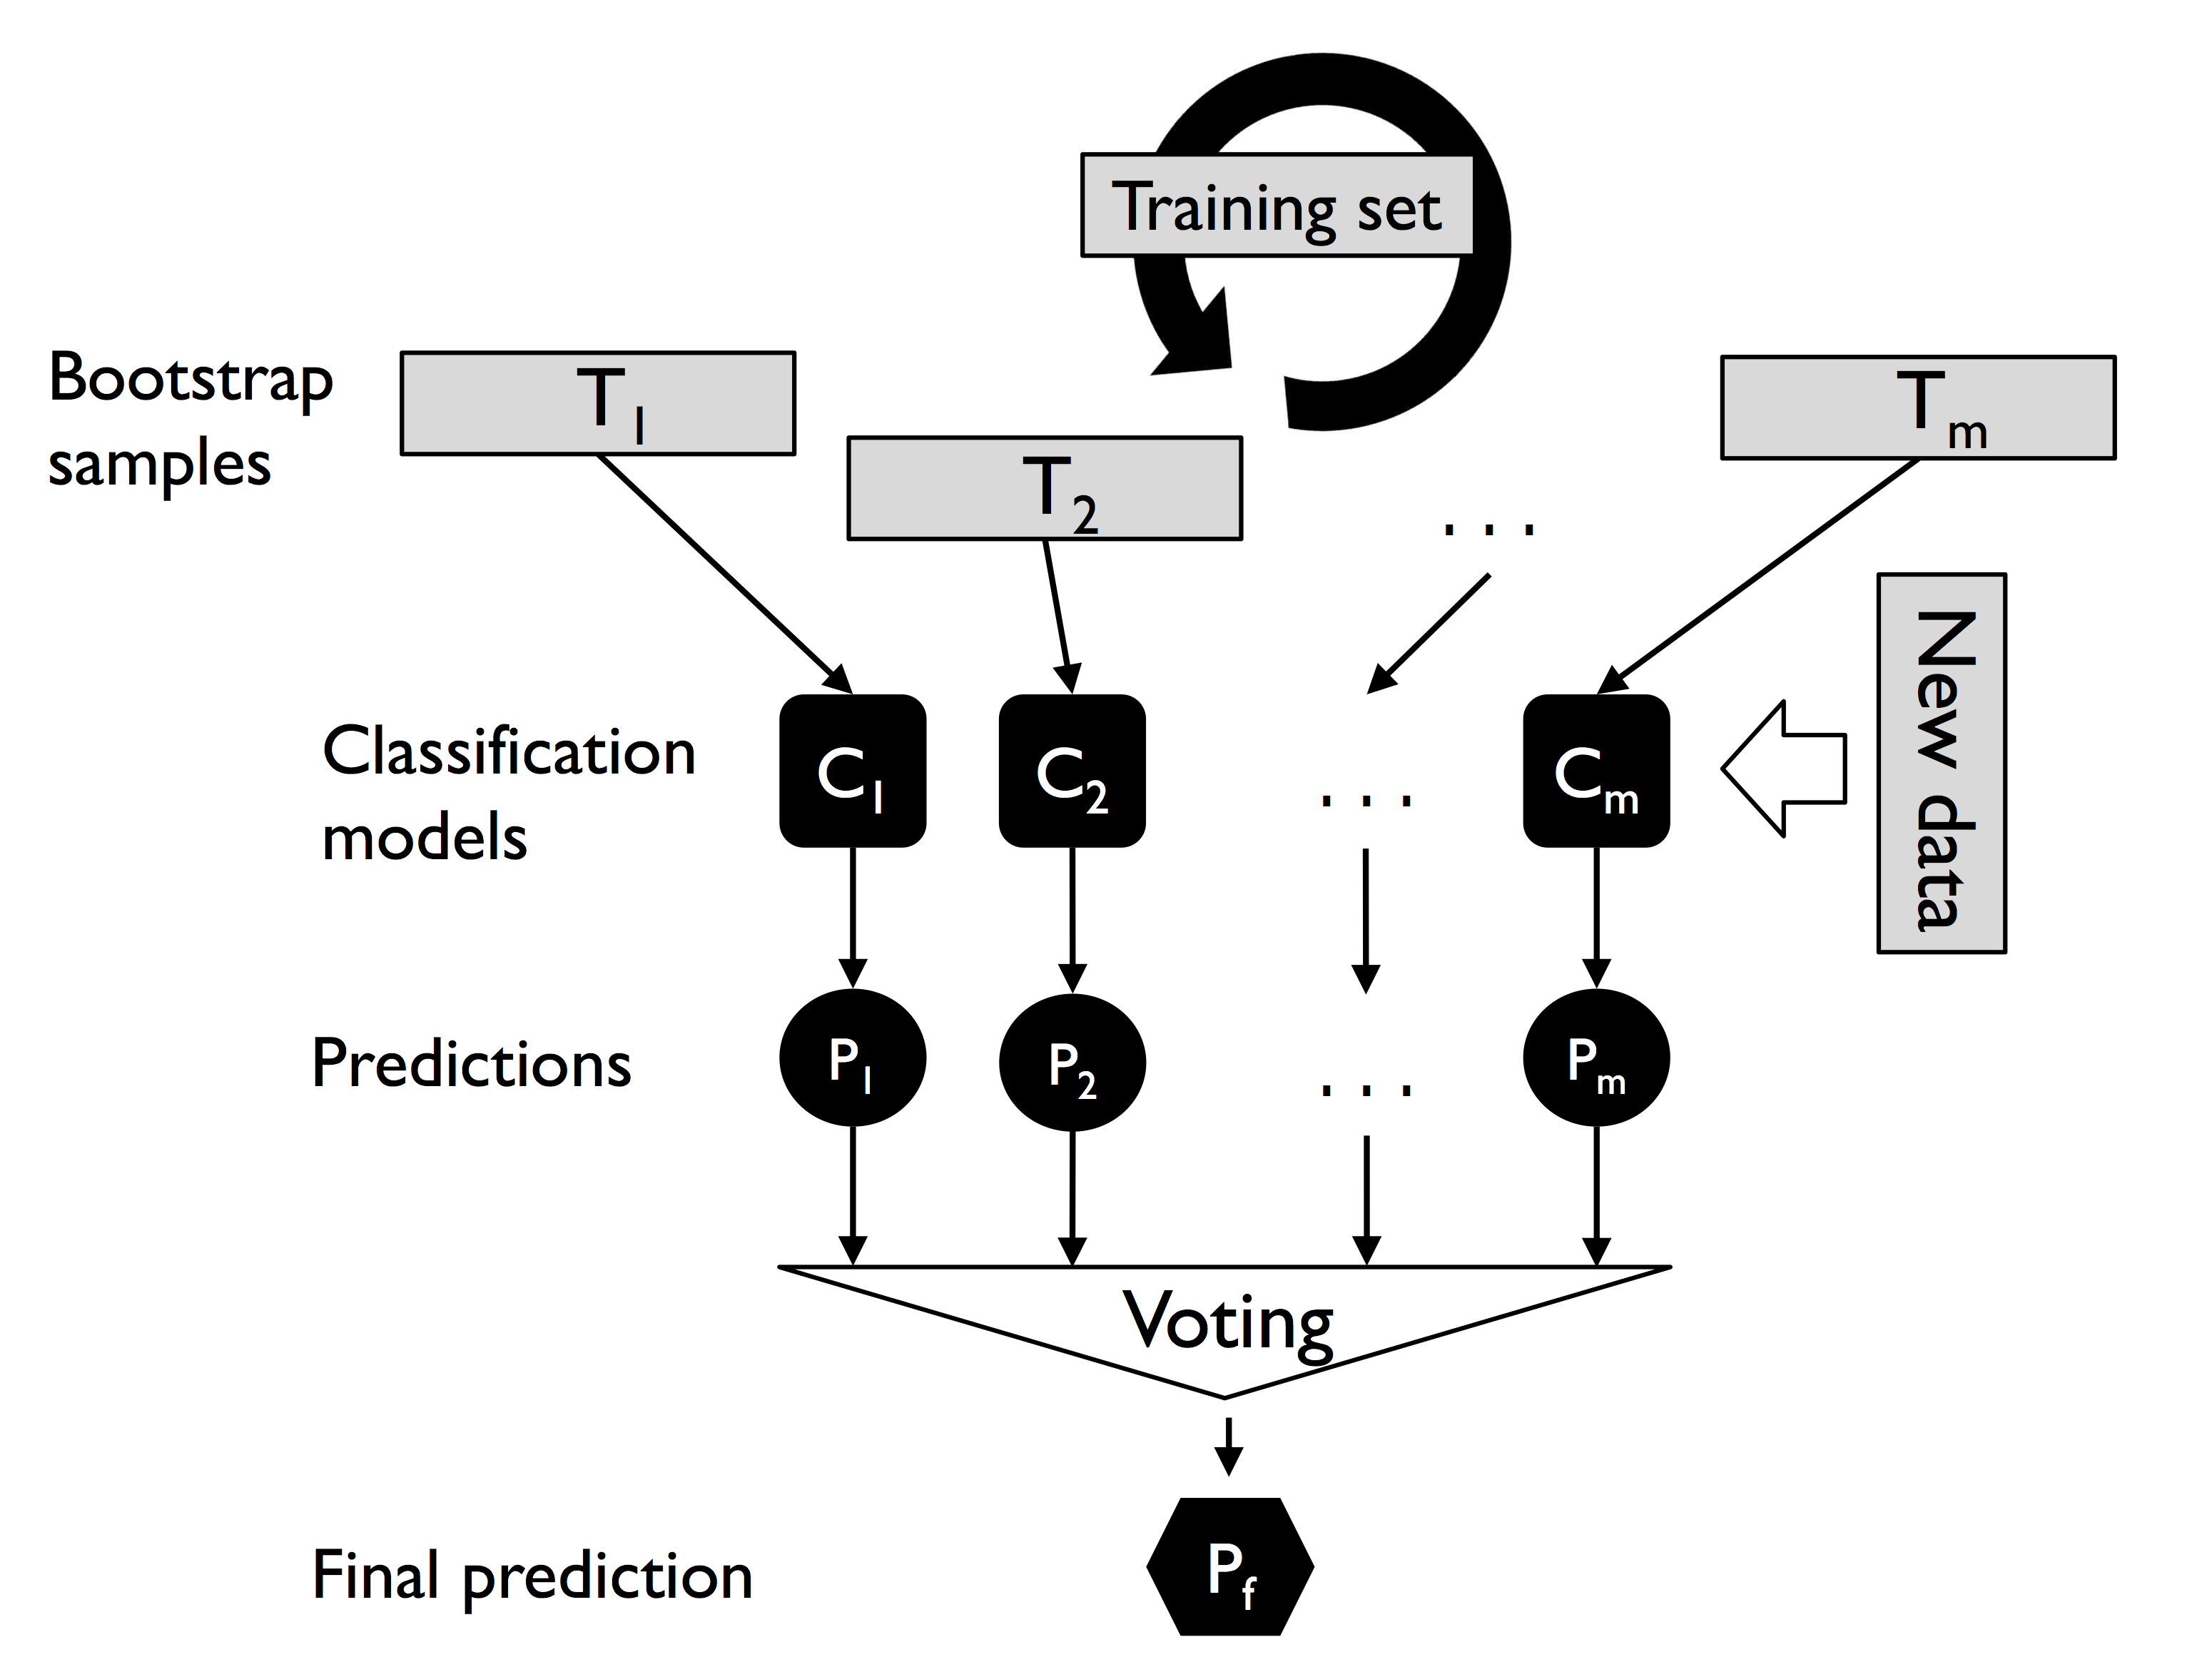

In [20]:
Image('img/07_06.png', width=500)

### 7.4.1 Bagging in a nutshell
---

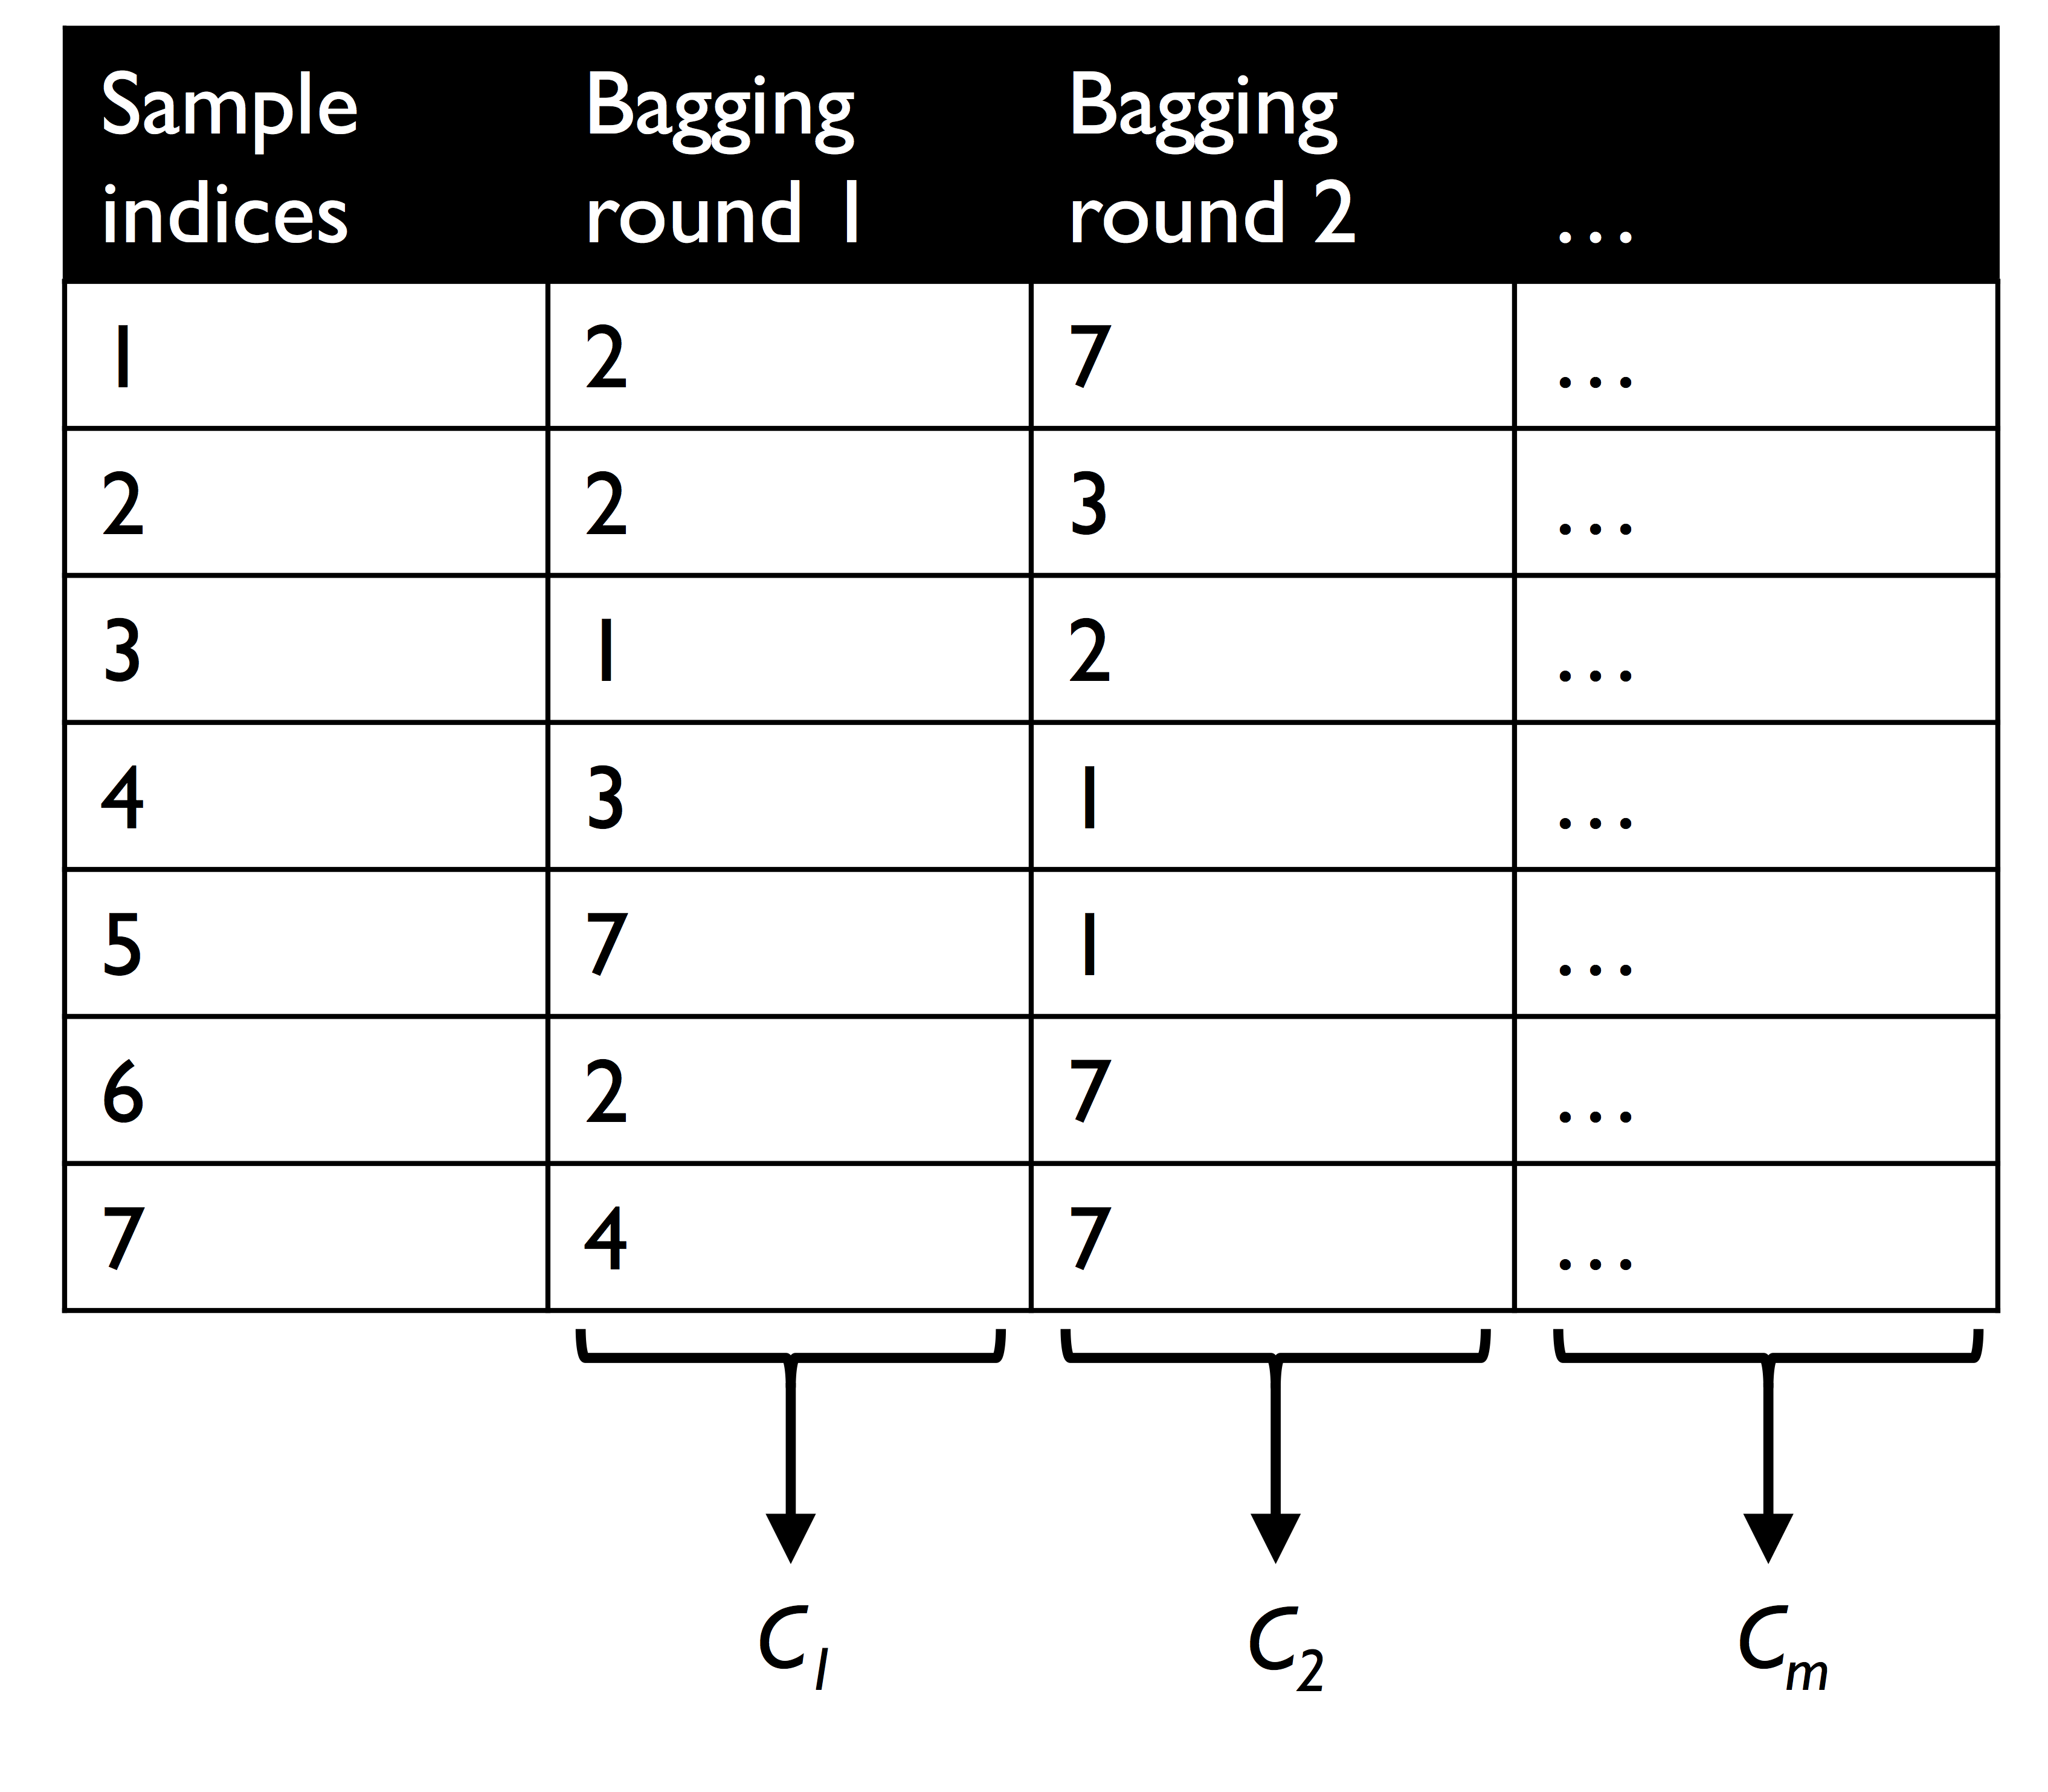

In [21]:
Image('img/07_07.png', width=500)

> ---
> 
> Leo Breiman 
> - [Breiman, L. (1996). Bagging predictors. Machine learning, 24(2), 123-140.](https://link.springer.com/content/pdf/10.1007/BF00058655.pdf)
> 
> ---

### 7.4.2 Applying bagging to classify samples in the Wine dataset
---

Wine dataset の calss 2, 3 を使って, 
feat: "Alcohol", "OD280/OD315 of diluted wines"

In [22]:
import pandas as pd

df_wine = pd.read_csv('data/wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 
                   'Alcalinity o ash', 'Magnesium', 'Total phnols', 'Flavanoids', 
                   'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 
                   'Hue', 'OD280/OD315 of diluted wines', 'Proline']

# remove class 1
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [23]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1, 
                                                    stratify=y)

```BaggingClassifier```

In [24]:
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None, 
                              random_state=1)

bag = BaggingClassifier(base_estimator=tree, 
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

In [25]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracies: %.3f / %.3f' % (tree_train, tree_test))

Decision tree train/test accuracies: 1.000 / 0.833


In [26]:
bag = bag.fit(X_train, y_train)

y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

print('Bagging train/test accuraciess: %.3f / %.3f' % (bag_train, bag_test))

Bagging train/test accuraciess: 1.000 / 0.917


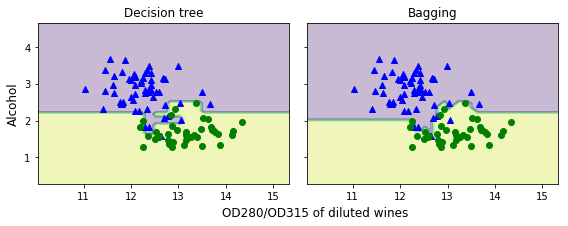

In [27]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), 
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', sharey='row', 
                        figsize=(8, 3))
for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], 
                       X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], 
                       X_train[y_train==1, 1], c='green', marker='o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.text(10.2, -0.5, 
         s='OD280/OD315 of diluted wines', 
         ha='center', va='center', fontsize=12)
plt.tight_layout()
plt.show()

## 7.5 Leveraging weak learner via adaptive boosting
---

**Boosting**
- &isin; ensemble
- e.g., **AdaBoost** (adaptive boosting)

> ---
> 
> - [Schapire, R. E. (1990). The strength of weak learnability. Machine learning, 5(2), 197-227.](https://link.springer.com/content/pdf/10.1007/BF00116037.pdf)
> - [Freund, Y., & Schapire, R. E. (1996, July). Experiments with a new boosting algorithm. In Icml (Vol. 96, pp. 148-156).](http://www.public.asu.edu/~jye02/CLASSES/Fall-2005/PAPERS/boosting-icml.pdf)
> 
> ---

Boosting
- 単純な base classifier で構成される (**Weak learner**: 当て推量を上回る程度)
- 誤分類されたtraining sample を後から, weak leaner で学習させることで, ensembleの性能を向上させる

### 7.5.1 How boosting works
---

#### boosting algo:

1. training dataset $D$ から, randomな subset $d_1$ を非復元抽出し, weak learner $C_1$ を training する
2. training subset $d_2$ を 非復元抽出し, 以前に誤分類された sample の50% を追加して, weak learner $C_2$ をtraining
3. training dataset $D$ から $C_1$, $C_2$ の結果が異なる training sample $d_3$を洗い出し, weak learner $C_3$ を training
4. weak learner $C_1$, $C_2$, $C_3$ を majority voting により組み合わせる

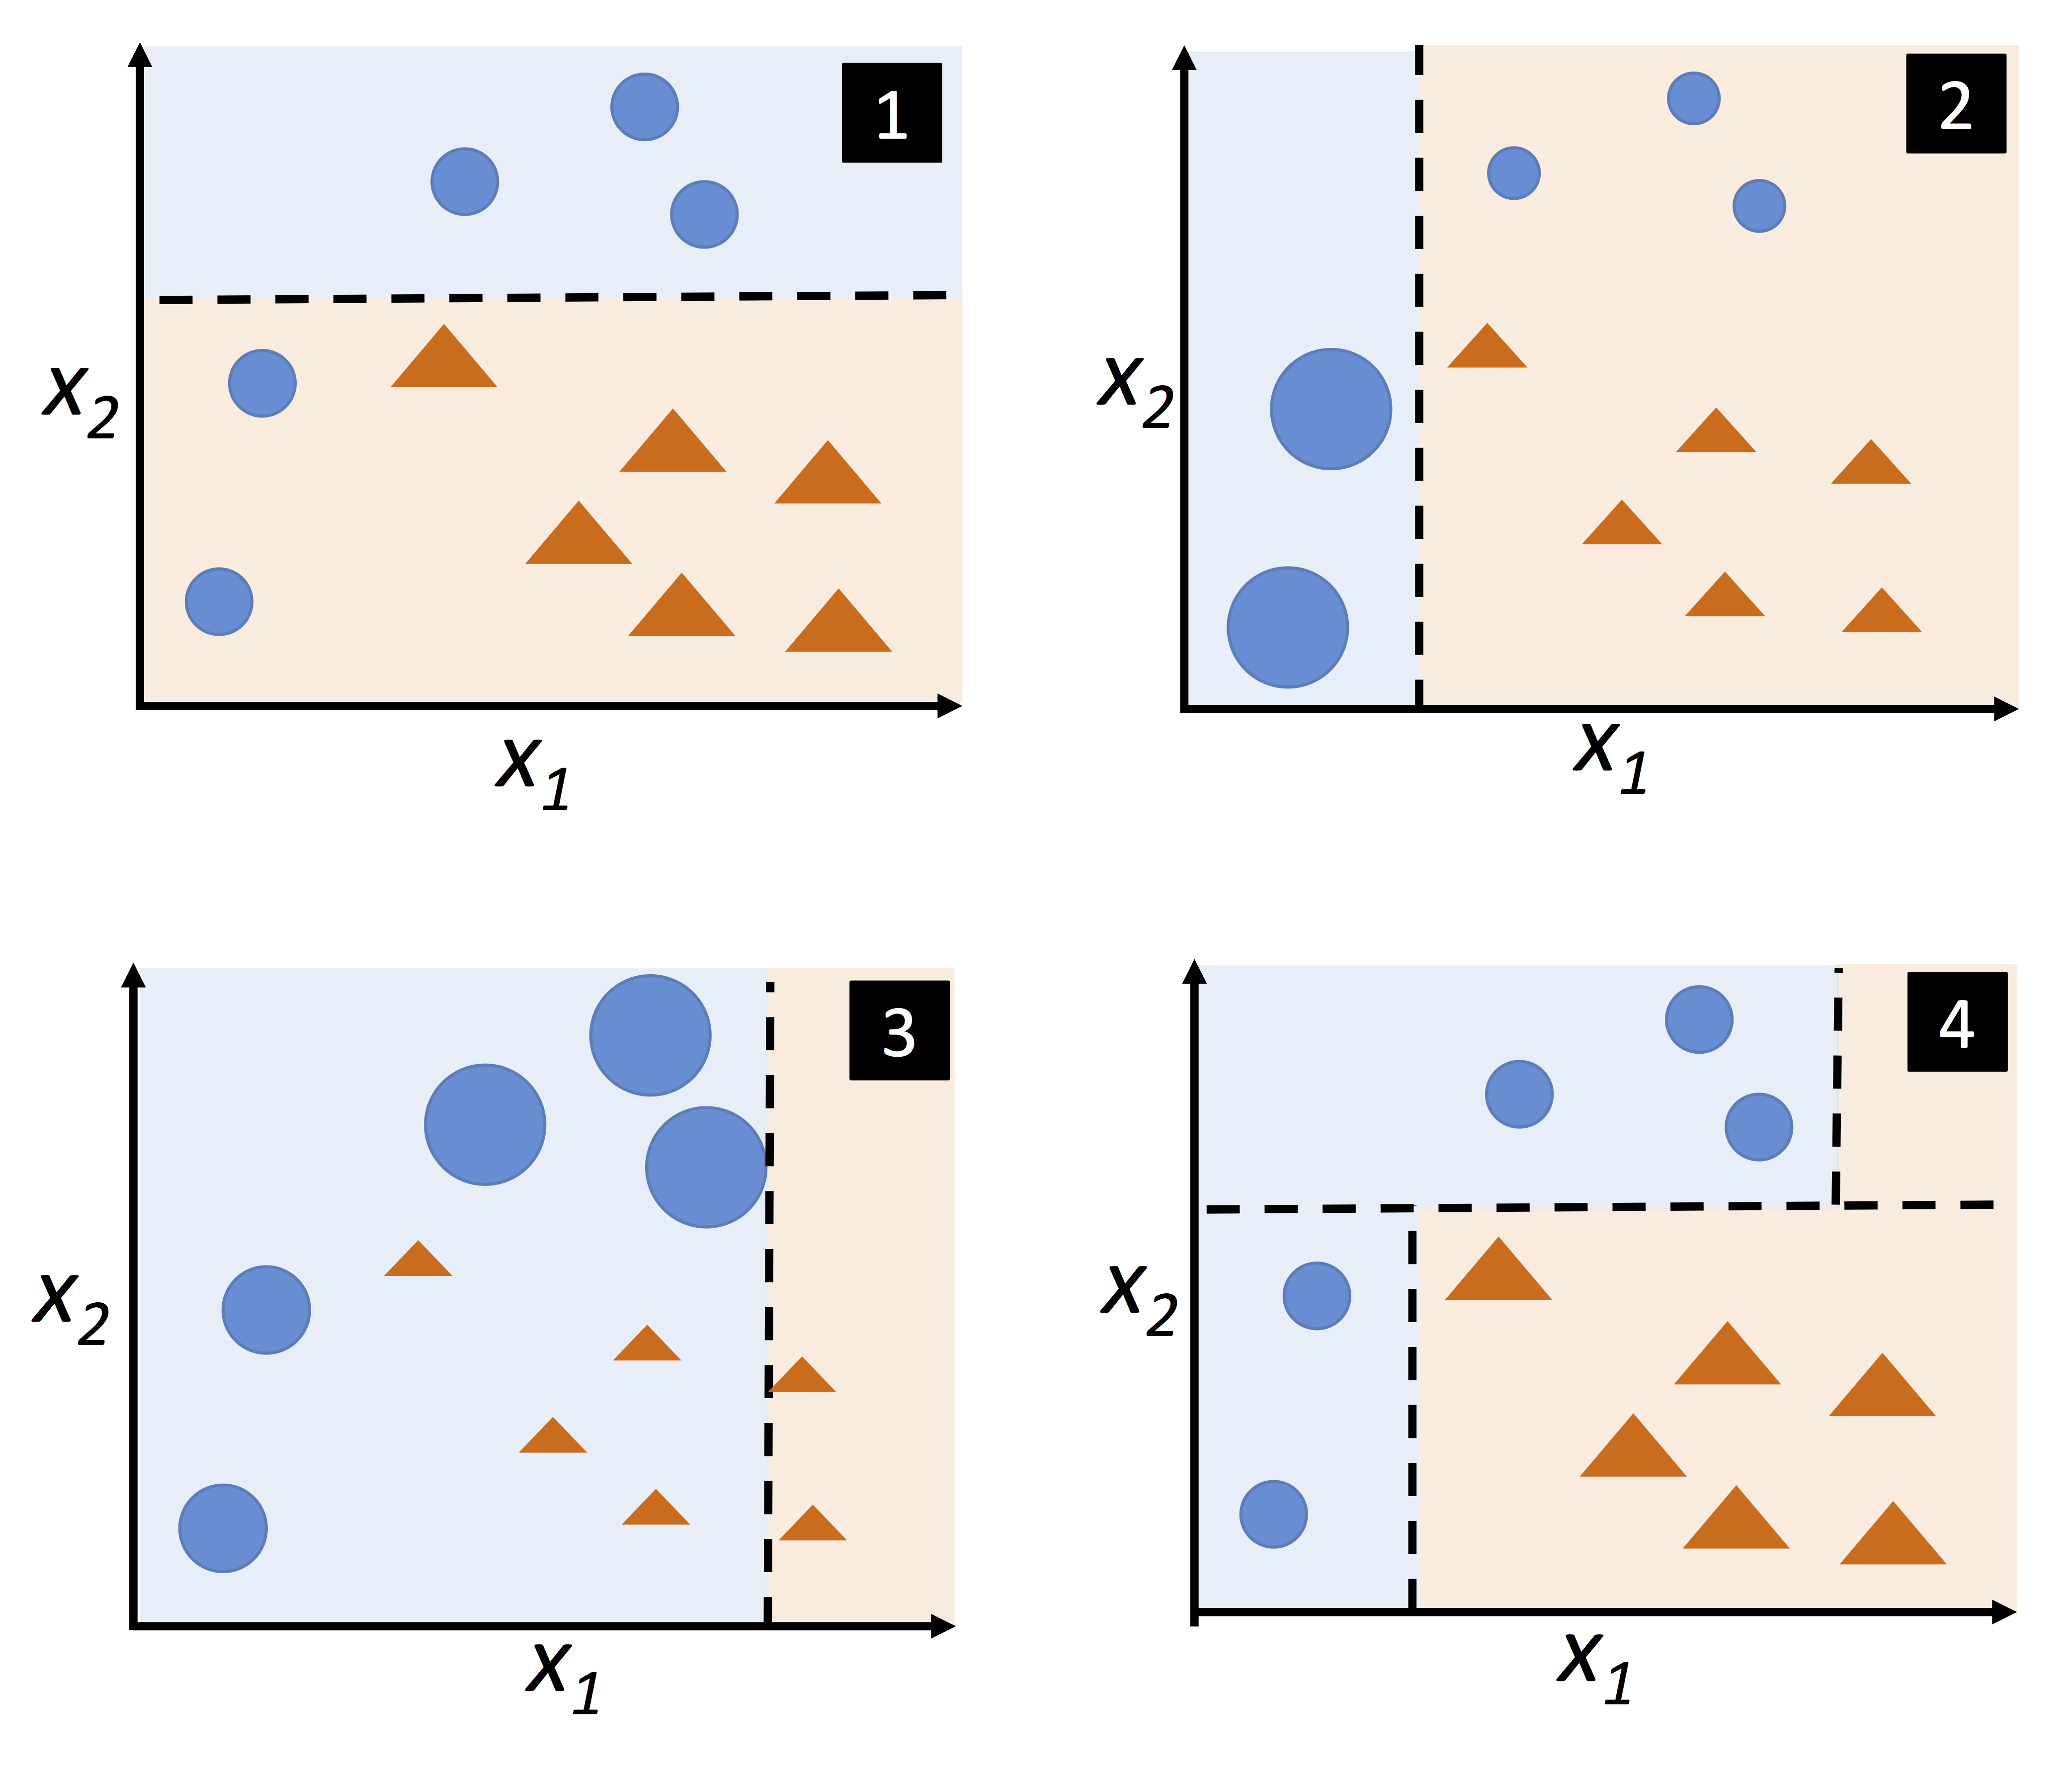

In [28]:
Image('img/07_09.png', width=500)

- fig 1
    - 全てのtraining sample が等しくweight
- fig 2, 3
    - 誤分類されたsample の weight を大きく
- fig 4
    - 3つの weak learner のweighted majority voting

- $\times$
- $•$: 内積
- $X$: feat mat
- $y$: class label



1: 
    - $w$: training sample weight vector
    - $w_i$: i-th sample weight
次が満たされるように, すべての$w$を等しくする ($w_i = \frac{1}{N}$)

$$\sum_i w_i = 1$$

2: m回実行する boostingのうち, j-th step ($j = 1, ..., m$)

a: weighted weak learner $C_j$
    
$$C_j = \text{train}(X, y, w)$$
    
b: class label $\widehat{y}$
    
$$\widehat{y} = \text{predict} (C_j, X)$$

c: weighted 誤分類率
    
$$\epsilon = w • (\widehat{y} ≠ y)$$
    
d: weight の update に用いる 係数 $\alpha_j$
    
$$\alpha_j = 0.5 \log \frac{1 - \epsilon}{\epsilon}$$
    
e: update weight
    
$$w := w \times \text{exp}(- \alpha_j \times \widehat{y} \times y)$$

f: weight を正規化して, 合計1になるように
    
$$w := \frac{w}{\sum_{i} w_i}$$


3: feat $X$ に対する 最終予測 $\widehat{y}$ を計算. step で推定した weight $\alpha_j$ で予測結果を重みづけた 平均 > 0 $y_i = 1$, 平均 ≤ 0 $y_i = -1$

$$\widehat{y} = \Bigg( \sum_{j=1}^m \Big( \alpha_j \times \text{predict}(C_j, X) \Big) > 0 \Bigg)$$

- 2c: $(\widehat{y} ≠ y)$, 各成分が1 / 0 のvector. 予測が正しくない場合: 1, 正しい場合: 0

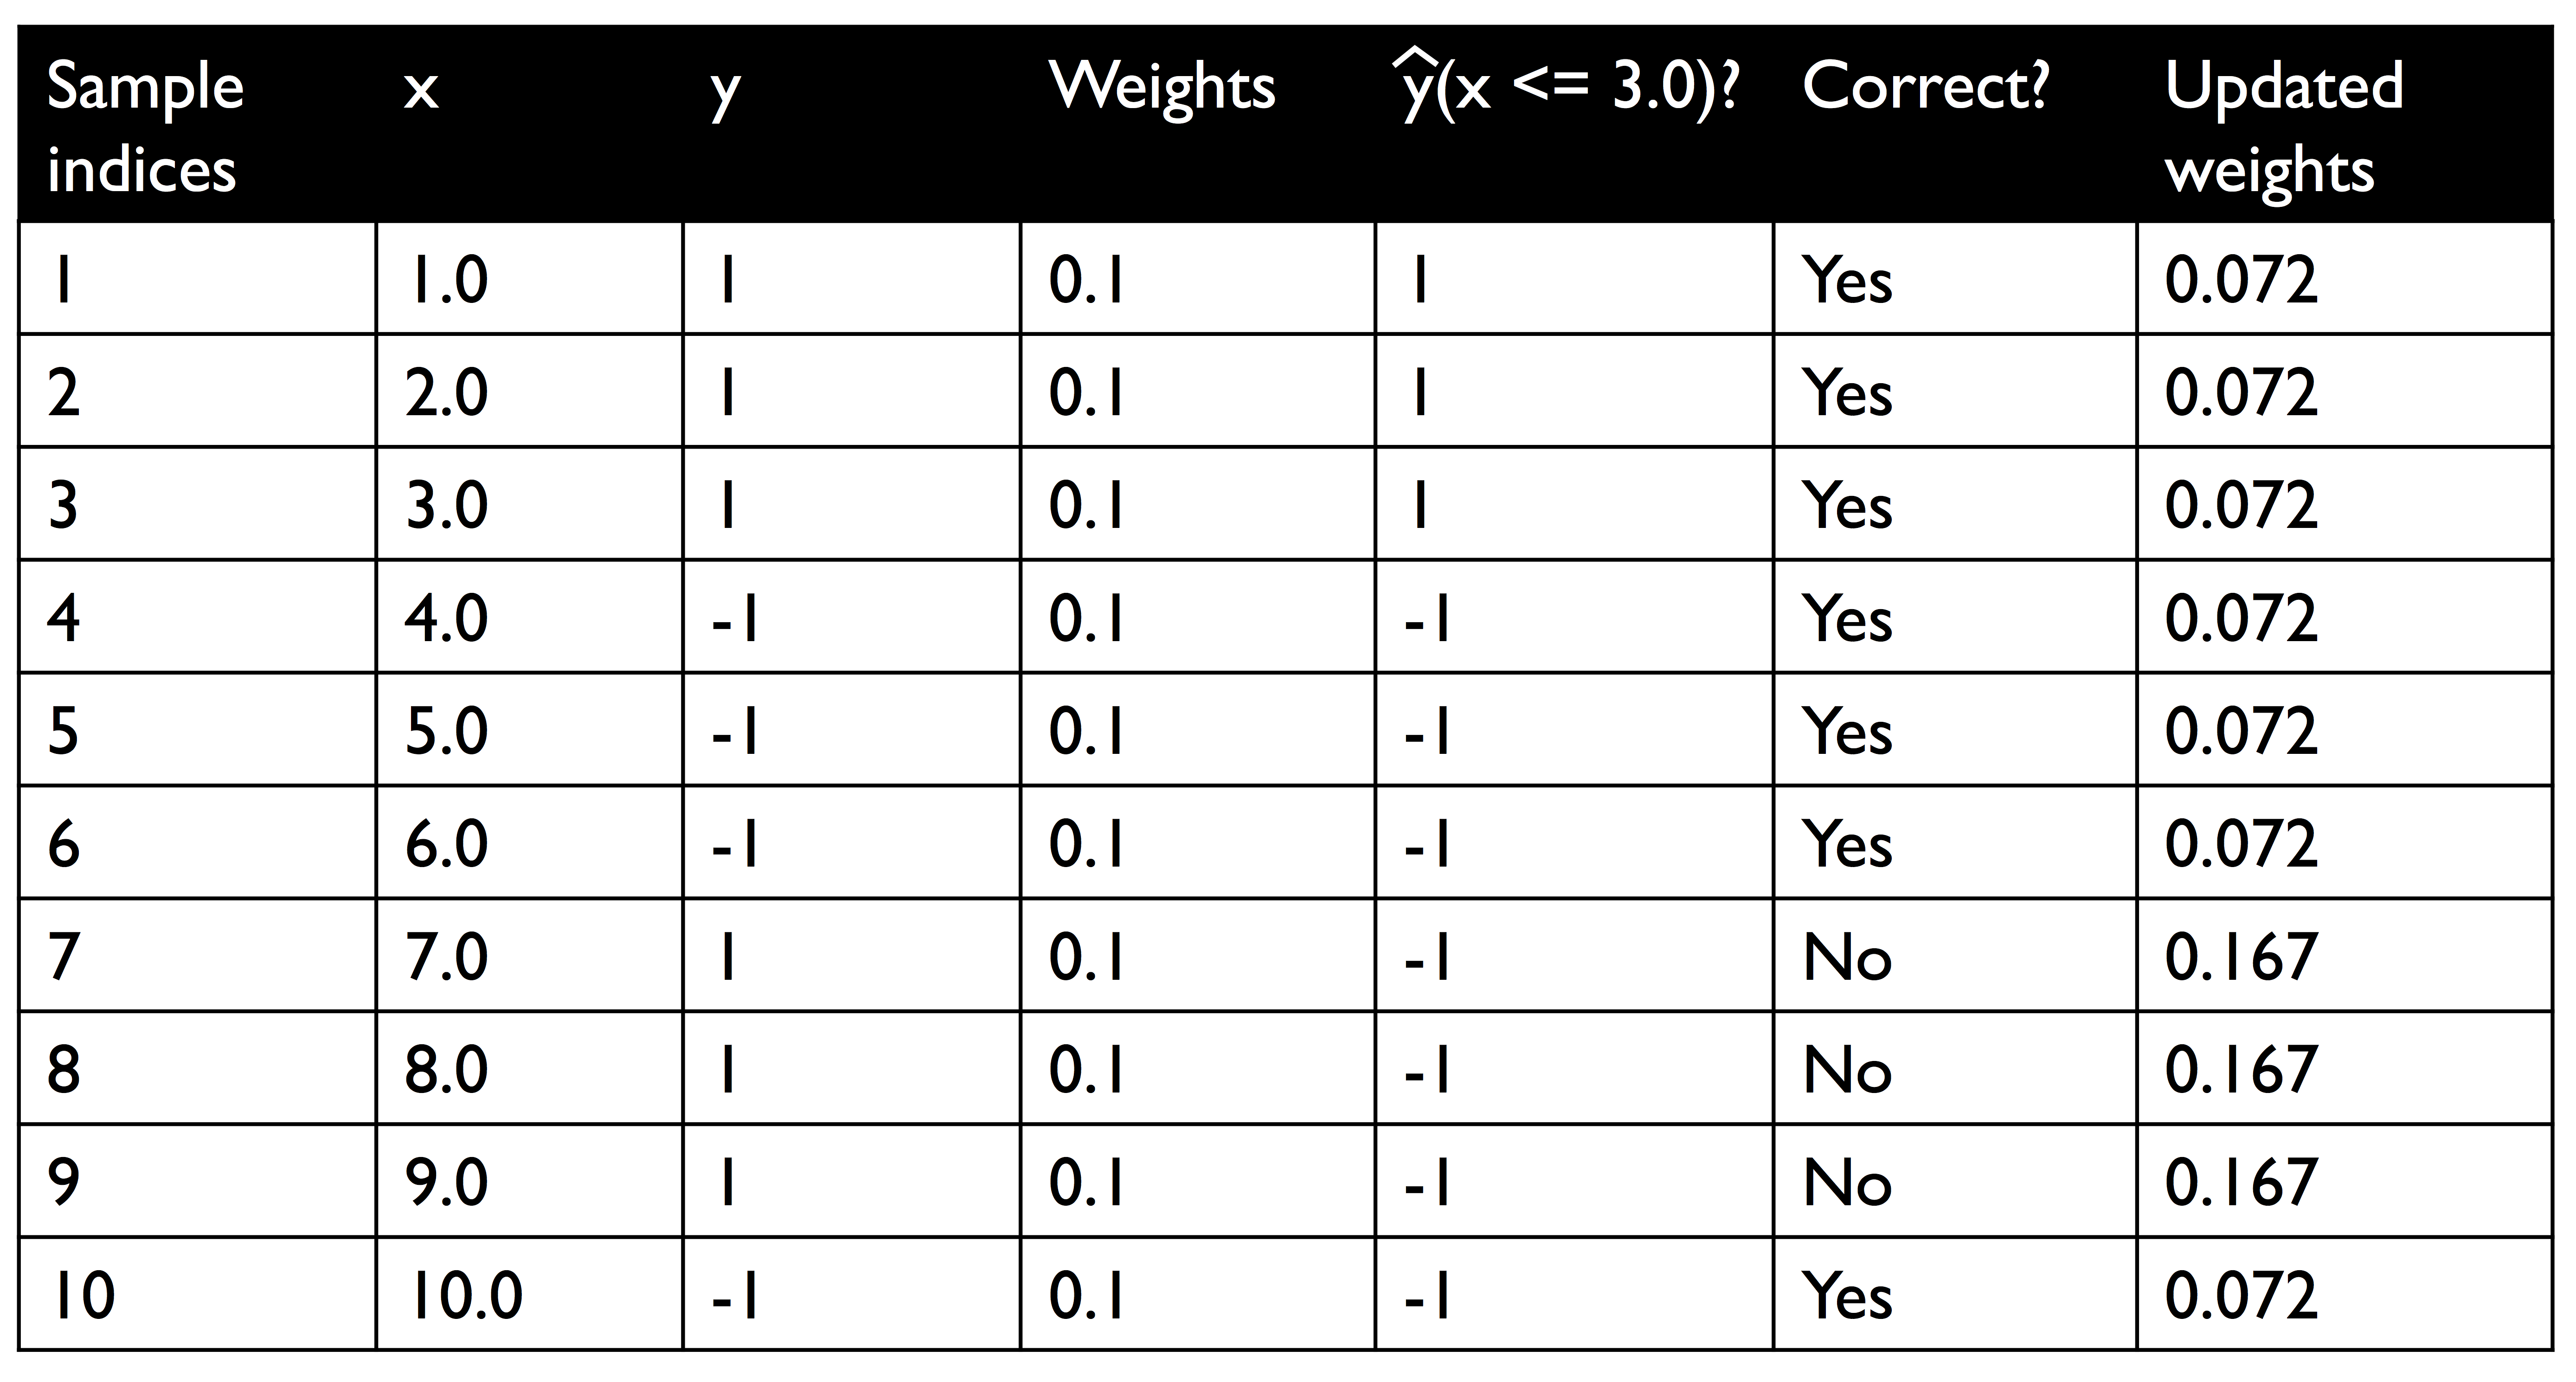

In [29]:
Image('img/07_10.png', width=500)

step 2c: 誤分類率 $\epsilon$

$$\begin{align*}
\epsilon &= 0.1 \times 0 + 0.1 \times 0 + 0.1 \times 0 + 0.1 \times 0 + 0.1 \times 0 + 0.1 \times 0 + 0.1 \times 1 + 0.1 \times 1 + 0.1 \times 1 + 0.1 \times 0 \\
&= 0.3
\end{align*}$$
(7.5.1)

step 2d: $\alpha_j$ を計算, step 2e

$$\begin{align*}
\alpha_j 
&= 0.5 \log \bigg( \frac{1 - \epsilon}{\epsilon} \bigg) \\
& \approx 0.424
\end{align*}$$
(7.5.2)

係数 $\alpha_j$ を計算した後, weight $w$ を update

$$w := w \times \exp (- \alpha_j \times \widehat{y} \times y)$$
(7.5.3)

$\widehat{y} \times y$ predicted label $\widehat{y}$, true label $y$ 

予測が正しい &xrArr; $\widehat{y}_i \times y_i$: (+) &xrArr; &darr;weight
$$0.1 \times \exp(-0.424 \times 1 \times 1) \approx 0.065$$
(7.5.4)

予測が正しくない &xrArr; $\widehat{y}_i \times y_i$: (-) &xrArr; &uarr;weight
$$0.1 \times \exp(-0.424 \times 1 \times (-1)) \approx 0.153$$
(7.5.5)

$$0.1 \times \exp(-0.424 \times (-1) \times 1) \approx 0.153$$
(7.5.6)

$$w := \frac{w}{\sum_i w_i}$$
(7.5.7)

$$
\begin{align*}
\sum_i w_i 
&= 7 \times 0.0065 + 3 \times 0.153 \\
&= 0.914
\end{align*}
$$
(7.5.8)

### 7.5.2 Applying AdaBoost using scikit-learn
---

In [30]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1, 
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree, 
                         n_estimators=500, 
                         learning_rate=0.1, 
                         random_state=1)

tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

Decision tree train/test accuracies 0.916/0.875


In [31]:
ada = ada.fit(X_train, y_train)

y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)

print('AdaBoost train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

AdaBoost train/test accuracies 1.000/0.917


In [32]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), 
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))

for idx, clf, tt in zip([0, 1], [tree, ada], ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], 
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], 
                       c='green', marker='o')
    
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.text(10.2, -0.5, 
         s='OD280/OD315 of duluted wines', 
         ha='center', 
         va='center', 
         fontsize=12)
plt.tight_layout()
plt.show()

---
> - [2009. "The BigChaos Solution to the Netflix Grand Prize"](https://www.netflixprize.com/assets/GrandPrize2009_BPC_BigChaos.pdf)
> - [Netflix prize](https://medium.com/netflix-techblog/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429)

**Overview**

- [7.1 Learning with ensembles](#7.1-Learning-with-ensembles)
- [7.2 Combining classifiers via majority vote](#7.2-Combining-classifiers-via-majority-vote)
    - [7.2.1 Implementing a simple majority vote classifier](#7.2.1-Implementing-a-simple-majority-vote-classifier)
    - [7.2.2 Using the majority voting principle to make predictions](#7.2.2-Using-the-majority-voting-principle-to-make-predictions)
- [7.3 Evaluating and tuning the ensemble classifier](#7.3-Evaluating-and-tuning-the-ensemble-classifier)
- [7.4 Bagging: Building an ensemble of classifiers from bootstrap samples](#7.4-Bagging:-Building-an-ensemble-of-classifiers-from-bootstrap-samples)
    - [7.4.1 Bagging in a nutshell](#7.4.1-Bagging-in-a-nutshell)
    - [7.4.2 Applying bagging to classify samples in the Wine dataset](#7.4.2-Applying-bagging-to-classify-samples-in-the-Wine-dataset)
- [7.5 Leveraging weak learner via adaptive boosting](#7.5-Leveraging-weak-learner-via-adaptive-boosting)
    - [7.5.1 How boosting works](#7.5.1-How-boosting-works)
    - [7.5.2 Applying AdaBoost using scikit-learn](#7.5.2-Applying-AdaBoost-using-scikit-learn)